In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import normaltest

%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set_palette('muted')

### Load/prep data

In [2]:
eth_price_raw = pd.read_csv('ethereum_price.csv')

In [3]:
# set df to manipulate
eth_price = eth_price_raw[['Date', 'Close']].copy()

# convert date to datetime
eth_price['Date'] = pd.to_datetime(eth_price['Date'], format='%b %d, %Y')
eth_price.sort_values('Date', inplace=True)
eth_price.reset_index(drop=True, inplace=True)

print(eth_price.shape)
print('number of nulls: {}'.format(eth_price.isnull().any().sum()))
eth_price.head()

(929, 2)
number of nulls: 0


,Date,Close
0,2015-08-07,2.770000
1,2015-08-08,0.753325
2,2015-08-09,0.701897
3,2015-08-10,0.708448
4,2015-08-11,1.070000


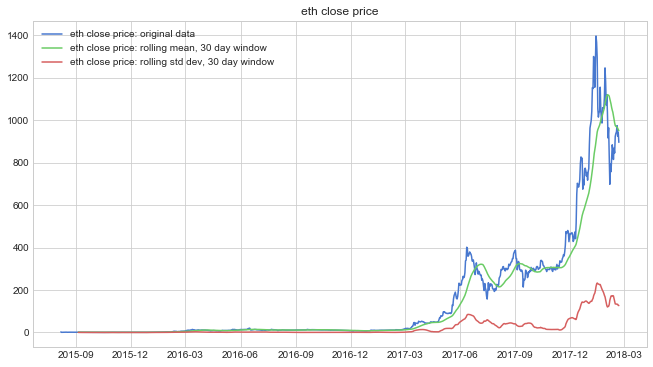

adf: -1.0177344392596426
pval: 0.7467412431946142
critical vals {'1%': -3.4375803238413085, '5%': -2.8647318597670877, '10%': -2.568469555703587}


In [4]:
plt.figure(figsize=(11,6))
plt.plot(
    eth_price['Date'],
    eth_price['Close'],
    label='eth close price: original data'
)
plt.plot(
    eth_price['Date'],
    eth_price['Close'].rolling(30).mean(),
    label='eth close price: rolling mean, 30 day window'
)
plt.plot(
    eth_price['Date'],
    eth_price['Close'].rolling(30).std(),
    label='eth close price: rolling std dev, 30 day window'
)
plt.title('eth close price')
plt.legend(loc='upper left')
plt.show()

from statsmodels.tsa.stattools import adfuller
print('adf: {0}\npval: {1}\ncritical vals {2}'.format(
    adfuller(eth_price['Close'])[0],
    adfuller(eth_price['Close'])[1],
    adfuller(eth_price['Close'])[4]))

In [5]:
eth_price.columns = ['date', 'close']
# try a couple methods to get stationary dataset
eth_price['diff_1'] = eth_price.close - eth_price.close.shift(1)
eth_price['diff_2'] = eth_price.close - eth_price.close.shift(2)
eth_price['log'] = np.log(eth_price.close)
eth_price = eth_price[2:]
eth_price.head()

,date,close,diff_1,diff_2,log
2,2015-08-09,0.701897,-0.051428,-2.068103,-0.353969
3,2015-08-10,0.708448,0.006551,-0.044877,-0.344679
4,2015-08-11,1.070000,0.361552,0.368103,0.067659
5,2015-08-12,1.220000,0.150000,0.511552,0.198851
6,2015-08-13,1.830000,0.610000,0.760000,0.604316


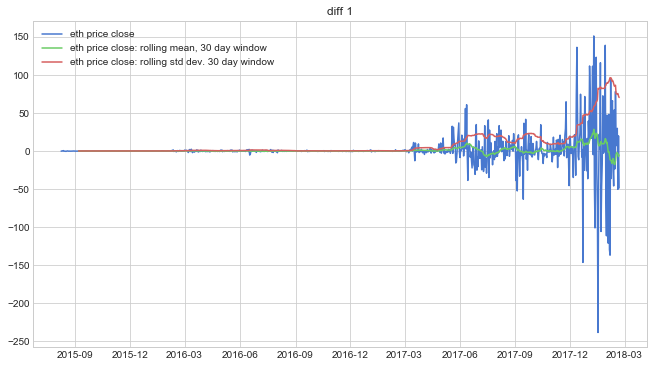

adf: -4.190611873493565
pval: 0.0006834299211675219
critical vals {'1%': -3.437596348122793, '5%': -2.86473892523805, '10%': -2.5684733191905007}


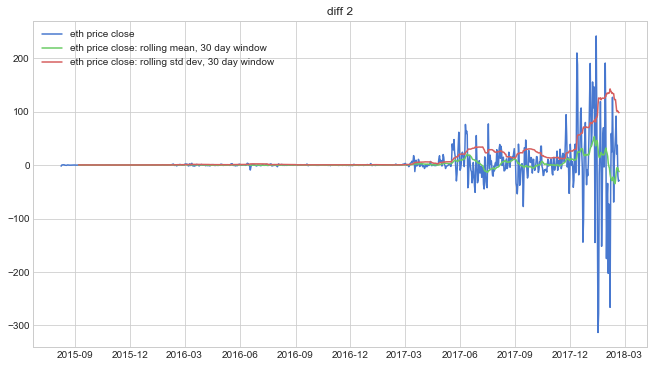

adf: -5.460598724328798
pval: 2.5237400496954937e-06
critical vals {'1%': -3.437596348122793, '5%': -2.86473892523805, '10%': -2.5684733191905007}


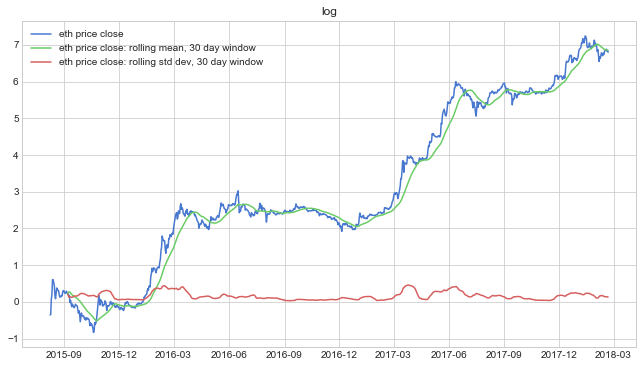

adf: -0.07869626518082977
pval: 0.9515195588976184
critical vals {'1%': -3.437454636606558, '5%': -2.8646764401027336, '10%': -2.5684400361180333}


In [6]:
# 1st order difference plot
plt.figure(figsize=(11,6))
plt.plot(
    eth_price['date'],
    eth_price['diff_1'],
    label='eth price close'
)
plt.plot(
    eth_price['date'],
    eth_price['diff_1'].rolling(30).mean(),
    label='eth price close: rolling mean, 30 day window'
)
plt.plot(
    eth_price['date'],
    eth_price['diff_1'].rolling(30).std(),
    label='eth price close: rolling std dev. 30 day window'
)
plt.title('diff 1')
plt.legend(loc='upper left')
plt.show()

print('adf: {0}\npval: {1}\ncritical vals {2}'.format(
    adfuller(eth_price['diff_1'])[0],
    adfuller(eth_price['diff_1'])[1],
    adfuller(eth_price['diff_1'])[4]))

# 2nd order difference plot
plt.figure(figsize=(11,6))
plt.plot(
    eth_price['date'],
    eth_price['diff_2'],
    label='eth price close'
)
plt.plot(
    eth_price['date'],
    eth_price['diff_2'].rolling(30).mean(),
    label='eth price close: rolling mean, 30 day window'
)
plt.plot(
    eth_price['date'],
    eth_price['diff_2'].rolling(30).std(),
    label='eth price close: rolling std dev, 30 day window'
)
plt.title('diff 2')
plt.legend(loc='upper left')
plt.show()

print('adf: {0}\npval: {1}\ncritical vals {2}'.format(
    adfuller(eth_price['diff_2'])[0],
    adfuller(eth_price['diff_2'])[1],
    adfuller(eth_price['diff_2'])[4]))

# log plot
plt.figure(figsize=(11,6))
plt.plot(
    eth_price['date'],
    eth_price['log'],
    label='eth price close'
)
plt.plot(
    eth_price['date'],
    eth_price['log'].rolling(30).mean(),
    label='eth price close: rolling mean, 30 day window'
)
plt.plot(
    eth_price['date'],
    eth_price['log'].rolling(30).std(),
    label='eth price close: rolling std dev, 30 day window'
)
plt.title('log')
plt.legend(loc='upper left')
plt.show()

print('adf: {0}\npval: {1}\ncritical vals {2}'.format(
    adfuller(eth_price['log'])[0],
    adfuller(eth_price['log'])[1],
    adfuller(eth_price['log'])[4]))

### Autocorrelation Functions (ACF/PACF)
- Using log return data as it had better adf results

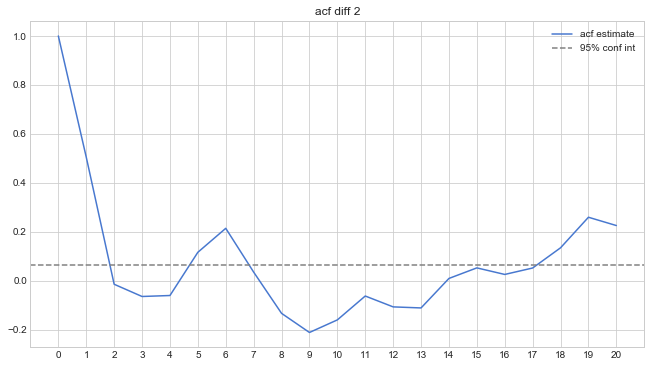

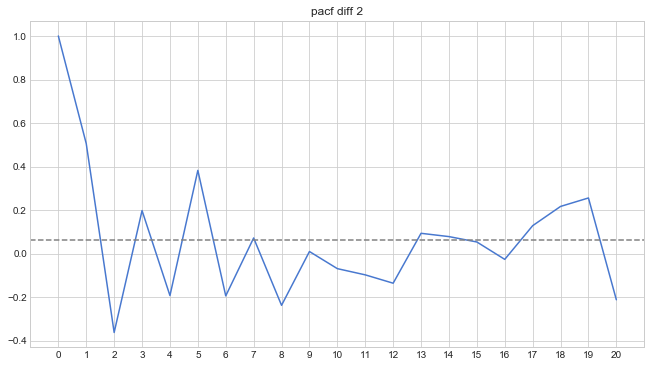

In [175]:
diff_2_acf = acf(eth_price.diff_2, nlags=20)
diff_2_pacf = pacf(eth_price.diff_2, nlags=20, method='ols')

plt.figure(figsize=(11,6))
plt.plot(diff_2_acf, label='acf estimate')
plt.axhline(y=1.96/np.sqrt(len(eth_price.diff_2)),
            linestyle='--',
            c='gray',
            label='95% conf int')
plt.xticks(np.arange(0,21))
plt.title('acf diff 2')
plt.legend()
plt.show()

plt.figure(figsize=(11,6))
plt.plot(diff_2_pacf, label='pacf estimate')
plt.axhline(y=1.96/np.sqrt(len(eth_price.diff_2)),
            linestyle='--',
            c='gray',
            label='95% conf int')
plt.xticks(np.arange(0,21))
plt.title('pacf diff 2')
plt.show()

ARIMA(p,d,q) for log_return
- $p=1$
- $q=1$

In [176]:
ar1_model = ARIMA(eth_price.diff_2, order=(1,0,0)).fit()
ar2_model = ARIMA(eth_price.diff_2, order=(2,0,0)).fit()

print(ar1_model.summary())
print(ar2_model.summary())

#s_ma, p_ma = normaltest(ma_model.resid)
#rss_ma = sum((ma_model.fittedvalues-eth_price.log_return) ** 2)
#plt.figure(figsize=(11,6))
#plt.suptitle('residuals: log_return ma model')
##plt.plot(ma_model.resid)
#plt.title('RSS: {0}\nnormaltest: s = {1}, p = {2}'
#          .format(rss_ma, s_ma, p_ma))
#plt.show()

#print(ar_ma_model.summary())
#s_ar_ma, p_ar_ma = normaltest(ar_ma_model.resid)
#rss_ar_ma = sum((ar_ma_model.fittedvalues-eth_price.log_return) ** 2)
#plt.figure(figsize=(11,6))
#plt.suptitle('residuals: log_return ar ma model')
#plt.plot(ar_ma_model.resid)
#plt.title('RSS: {0}\nnormaltest: s = {1}, p = {2}'
#          .format(rss_ar_ma, s_ar_ma, p_ar_ma))
#plt.show()

#print('quick comparison:')
#print('\nar(1) model:\nAIC: {0}, RSS: {1:.6f}'.format(ar_model.aic, rss_ar))
#print('\nma(1) model:\nAIC: {0}, RSS:{1:.6f}'.format(ma_model.aic, rss_ma))
#print('\ncombined model:\nAIC: {0}, RSS:{1:.6f}'.format(ar_ma_model.aic, rss_ar_ma))

                              ARMA Model Results                              
Dep. Variable:                 diff_2   No. Observations:                  927
Model:                     ARMA(1, 0)   Log Likelihood               -4413.340
Method:                       css-mle   S.D. of innovations             28.270
Date:                Sat, 08 Sep 2018   AIC                           8832.680
Time:                        14:37:39   BIC                           8847.176
Sample:                             0   HQIC                          8838.209
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.9422      1.873      1.037      0.300      -1.730       5.614
ar.L1.diff_2     0.5049      0.028     17.821      0.000       0.449       0.560
                                    Roots   

In [181]:
ma1_model = ARIMA(eth_price.diff_2, order=(0,0,1)).fit()
ar2_ma1 = ARIMA(eth_price.diff_2, order=(2,0,1)).fit()

print(ma1_model.summary())
print(ar2_ma1.summary())

                              ARMA Model Results                              
Dep. Variable:                 diff_2   No. Observations:                  927
Model:                     ARMA(0, 1)   Log Likelihood               -4203.203
Method:                       css-mle   S.D. of innovations             22.457
Date:                Sat, 08 Sep 2018   AIC                           8412.406
Time:                        14:42:42   BIC                           8426.902
Sample:                             0   HQIC                          8417.936
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.9236      1.474      1.305      0.192      -0.966       4.813
ma.L1.diff_2     1.0000      0.003    305.144      0.000       0.994       1.006
                                    Roots   

### Forecasting

In [136]:
# forecast the last 30 days of the time series
# set df leaving out last 30 days

X = pd.DataFrame()
X['date'] = eth_price['Date'].copy()
X['actual'] = eth_price['log_return']
X['forecast'] = eth_price['log_return'][:-30]
X.reset_index(drop=True, inplace=True)
print(eth_price.shape, X.shape)

(927, 4) (927, 3)


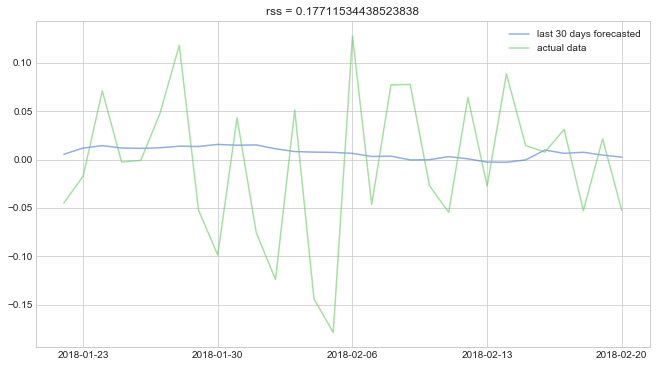

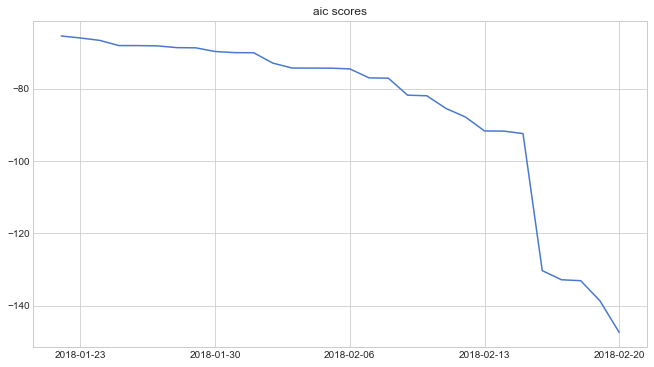

In [137]:
start = 60
ar_aic = []

while X.forecast.isnull().any() == True:
    
    data = X[-start:-X.forecast.isnull().sum()]
    ar = ARIMA(data.forecast, order=(1,0,0)).fit()
    X.forecast[len(X) - X.forecast.isnull().sum()] = ar.forecast()[0]
    ar_aic.append(ar.aic)
    start -= 1

ar_rss = sum((X.forecast[-30:] - X.actual[-30:]) ** 2)

plt.figure(figsize=(11,6))
plt.plot(X.date[-30:], X.forecast[-30:], label='last 30 days forecasted', alpha=.6)
plt.plot(X.date[-30:], X.actual[-30:], label='actual data', alpha=.6)
plt.title('rss = {}'.format(rss))
plt.legend()
plt.show()

plt.figure(figsize=(11,6))
plt.plot(X.date[-30:], aic)
plt.title('aic scores')
plt.show()

In [134]:
X_arima = pd.DataFrame()
X_arima['date'] = eth_price['Date'].copy()
X_arima['actual'] = eth_price['log_return']
X_arima['forecast'] = eth_price['log_return'][:-30]
X_arima.reset_index(drop=True, inplace=True)
print(X_arima.shape)

(927, 3)


In [135]:
start = 60
arima_aic = []

while X_arima.forecast.isnull().any() == True:
    data = X_arima[-start:X_arima.forecast.isnull().sum()]
    arima = ARIMA(data.forecast, order=(1,0,1)).fit()
    X_arima[len(X_arima) - X_arima.forecast.isnull().sum()] = arima.forecast()[0]
    arima_aic.append(arima.aic)
    start -= 1
    
arima_rss = sum((X_arima.forecast[-30:] - X_arima.actual[-30:]) ** 2)
print(len(arima_aic), arima_rss)

ValueError: Insufficient degrees of freedom to estimate

In [10]:
from sklearn.metrics import mean_squared_error

# 30 day window
window = 30

# Set up data
X = pd.DataFrame()
X['date'] = eth_price['Date'].copy()
#X['log_return_actual'] = eth_price['log_return']
X['log_return_forecast'] = eth_price['log_return'][:window]
X.reset_index(drop=True, inplace=True)
print(X.shape)

(927, 2)


In [11]:
for n in range(len(X)):
    start = n
    stop = window + n
    if stop <= len(X):
        data = X[start:stop]
        model = ARIMA(data.log_return_forecast, order=(1,0,0)).fit()
        X.log_return_forecast[stop] = model.forecast()[0]
    else:
        break

plt.figure(figsize=(11,6))
plt.plot(X.date[:len(X)], X.log_return_forecast[:len(X)])
plt.show()

X2 = X.loc[X['log_return_forecast'] <= 0.01]
X2 = X2.loc[X2['log_return_forecast'] >= -0.01]
X2.reset_index(inplace=True, drop=True)

plt.figure(figsize=(11,6))
plt.plot(X2.date[:len(X2)], X2.log_return_forecast[:len(X2)])
plt.show()

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(11,6))
plt.plot(X.date[:len(X)], X.log_return_forecast[:len(X)])
plt.show()

X2 = X.loc[X['log_return_forecast'] <= 0.01]
X2 = X2.loc[X2['log_return_forecast'] >= -0.01]
X2.reset_index(inplace=True, drop=True)

plt.figure(figsize=(11,6))
plt.plot(X2.date[:len(X2)], X2.log_return_forecast[:len(X2)])
plt.show()

In [ ]:
stop 

### Exogenous variables
- **[CBOE Volatility Index (VIX)](https://en.wikipedia.org/wiki/VIX)**: measure of stock market's expectation of volatility implied by S&P 500 index options, aka 'fear index'
     - [Data Source](http://www.cboe.com/products/vix-index-volatility/vix-options-and-futures/vix-index/vix-historical-data)
- **[US Dollar Index (DXY)](https://en.wikipedia.org/wiki/U.S._Dollar_Index)**: measure of value of USD relative to a basket of foreign currencies
    - [Data Source](https://quotes.wsj.com/index/DXY/historical-prices)
- **[Federal Funds Rate (EFFR)](https://en.wikipedia.org/wiki/Federal_funds_rate)**: the interest rate at which depository institutions (banks and credit unions) lend reserve balances to other depository institutions overnight, on an uncollateralized basis 
    - [Data Source](https://fred.stlouisfed.org/series/EFFR)

In [ ]:
# date range
print('{}\n{}'.format(eth_price.Date.head(1),
                      eth_price.Date.tail(1)))
print(len(eth_price))

In [ ]:
vix_raw = pd.read_csv('vixcurrent.csv', header=1)
print(vix_raw.info())

In [ ]:
vix_raw[:1]

In [ ]:
vix_close = vix_raw[['Date', 'VIX Close']].copy()
vix_close['Date'] = pd.to_datetime(vix_close['Date'], format='%m/%d/%Y')
vix_close.sort_values('Date', inplace=True)
vix_close.reset_index(drop=True, inplace=True)
vix_close.head()

In [ ]:
vix_close = vix_close.loc[(vix_close['Date'] >= '2015-08-07')
                          & (vix_close['Date'] <= '2018-02-20')]

In [ ]:
vix_close.reset_index(drop=True, inplace=True)

In [ ]:
vix_close.tail()

In [ ]:
print(vix_close.shape)

In [ ]:
eth_exog = eth_price.merge(vix_close, how='outer', on='Date')
eth_exog.columns = ['date', 'eth_close', 'vix_close']
eth_exog.head(10)

In [ ]:
dxy_raw = pd.read_csv('dxy_historical.csv')
dxy_raw[:1]

In [ ]:
dxy_raw.info()

In [ ]:
dxy_close = dxy_raw[['Date', ' Close']].copy()
dxy_close['Date'] = pd.to_datetime(dxy_close['Date'], format='%x')
dxy_close.sort_values('Date', inplace=True)
dxy_close.reset_index(drop=True, inplace=True)
dxy_close.columns = ['date', 'close']
dxy_close.head()

In [ ]:
print(dxy_close.shape)

In [ ]:
eth_exog = eth_exog.merge(dxy_close, how='outer', on='date')
eth_exog.columns = ['date', 'eth_close', 'vix_close', 'dxy_close']
eth_exog.head(10)

In [ ]:
effr_raw = pd.read_csv('EFFR.csv')
effr_raw.head()

In [ ]:
effr = effr_raw.copy()
effr.columns = ['date', 'effr']
effr['date'] = pd.to_datetime(effr['date'], format='%Y-%m-%d')
effr.sort_values('date', inplace=True)
effr = effr.loc[(effr['date'] >= '2015-08-07') & (effr['date'] <= '2018-02-20')]
effr.reset_index(drop=True, inplace=True)
effr.head()

In [ ]:
effr.info()

In [ ]:
effr['effr'].value_counts().sort_values(ascending=True)

In [ ]:
print(effr.loc[effr['effr'] == '.'])
print('\n{}'.format(len(effr.loc[effr['effr'] == '.'])))

In [ ]:
eth_exog = eth_exog.merge(effr, how='outer', on='date')

In [ ]:
eth_exog.head()

In [ ]:
print(eth_exog.loc[eth_exog['effr'] == '.'])
print('\n{}'.format(len(eth_exog.loc[eth_exog['effr'] == '.'])))